In [1]:
import numpy as np
import random
import pickle
import nltk
import json
import re
import os
from HMM import unsupervised_HMM
from HMM_helper import sample_sentence, parse_observations
from string import punctuation
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import cmudict
from sklearn.feature_extraction.text import TfidfVectorizer

Lets first read in the sonnets and tokenize them. We will tokenize them both by line and by poem.  

In [2]:
f = open(os.getcwd()+'/data/shakespeare.txt')
lines = f.readlines()
all_words = []
new_lines = []
sonnets=[]
sonnet=[]
poems = []


for line in lines:
    line = line.strip()
    line = line.lower()
    newPun = "#$%&()*+/<=>@][^_`{|}~-"
#     line = ''.join(c for c in line if c not in newPunct)
    for punct in newPun:
        line = line.replace(punct, '')
    if line.isdigit():
        sonnets.append(sonnet)
        sonnet = []
    elif line.strip() == '':
        pass
    else:
        sonnet.append(line)
sonnets.append(sonnet)
del sonnets[0]


marking out the bad sonnets - later they were deleted 

bad_sonnets = []
for i in range(len(sonnets)):
    if len(sonnets[i]) != 14:
        bad_sonnets.append(i)

In [3]:
line_tokens = [] # tokens per line
poem_tokens = [] # tokens per poem
single_poem_tokens = []
for sonnet in sonnets:
    poem_tokens.append(single_poem_tokens)
    for line in sonnet:
            line_tokens.append(nltk.word_tokenize(line)) # this is all tokens in each line
            single_poem_tokens += nltk.word_tokenize(line)


The function below will create a dictionary we will use later to ensure the sonnet rhyme scheme is adhered to.

In [4]:
def make_dictionary(dictionary, word1, word2):
    """
    This function takes in a dictionary and two words. 
    It populates the dictionary with keys: word1
    values: word2
    
    """
    if word1 in dictionary:
        word_list = dictionary.get(word1)
        if word2 not in word_list:
            new_word_list = dictionary[word1]
            new_word_list.append(word2)
            dictionary[word1] = new_word_list
    else:
        dictionary[word1] = [word2]

    if word2 in dictionary:
        word_list = dictionary.get(word2)
        if word1 not in word_list:
            new_word_list = dictionary[word2]
            new_word_list.append(word1)
            dictionary[word2] = new_word_list
    else:
        dictionary[word2] = [word1]

    return dictionary

This lower cell reads in the syllable dictionary, then returns the list of words and the number of syllables in either the line or whole poem. 

In [5]:
# syllable_dictionary is a dictionary with all the words in the sonnets
# and how many syllables each word is 
syllables = {}
with open("./data/Syllable_dictionary.txt") as syllableDict:
    for line in syllableDict:
        split = line.split()
        if len(split) == 3:
            (key, end, val) = line.split()
        else:
            (key, val) = line.split()

        # they're ordered by syllable length, so sometimes the E is last
        try:
            syllables[key] = int(val)
        except:
            syllables[key] = int(end)

rhymes = {}
# sonnet format: abab cdcd efef gg
for j in range(len(line_tokens)-1):
    line = line_tokens[j]
    last_word = line[-1]
    i = (j % 14) + 1
    # using our dictionary function to create a dict where the values of a given key are all the words that rhyme with it
    if i == 1 or i == 2 or i == 5 or i == 6 or i == 9 or i == 10:
        rhymes = make_dictionary(rhymes, last_word, line_tokens[j+2][-1])
    elif i == 13:
        rhymes = make_dictionary(rhymes, last_word, line_tokens[j+1][-1])
    


This next function returns the sequences in the lines (not sure what this is to be honest), a dictionary with their encoding and the features (tokens).

In [6]:
sequences = [] 
seq_encode = [] 
features = []

# look through all tokens and 
for obs in poem_tokens:
    # assigning a POS tag to each token in that line
    seq = pos_tag(obs)
    poemFeatures = []
    # if it's a new sequence, add it to the list
    for pair in seq: 
        if pair[1] not in sequences:
            sequences.append(pair[1])
            seq_encode.append([])
            seq_encode[sequences.index(pair[1])].append([pair[0], 1])
        else: 
            firstCol = [row[0] for row in seq_encode[sequences.index(pair[1])]]
            if pair[0] not in firstCol:
                seq_encode[sequences.index(pair[1])].append([pair[0], 1])
            else:
                index = firstCol.index(pair[0])
                seq_encode[sequences.index(pair[1])][index][1] += 1
        
        # poemFeatures now contains the features of each token in the line
        poemFeatures.append(sequences.index(pair[1]))


    features.append(poemFeatures)


In [7]:
def generate_words(emission, POSlookup, syllables, reverse=False, lastWord=None):
    '''
    This function generates a string given the emissions and the probabilities 
    of a word being emitted given a certain
    Input:
        emission: The list of emission, which represents the POS of the word
        POSlookup: A 2D array being POS, [word, frequency] for the given POS
        syllables: The dictionary of words and number of syllables each word has
        reverse: Whether to start from beginning or end of line
        rhymes: Dictionary of different rhymes
    Output:
        emStr: The sentence generated
    '''
    done = False
    if reverse:
        assert(lastWord is not None)
        while not done:
            emStr = lastWord
            try:
                syllableCount = syllables[lastWord]
            except:
                syllableCount = 2
                print(lastWord)
            for obs in emission:
                emRate = [row[1] for row in POSlookup[obs]]
                emWords = [row[0] for row in POSlookup[obs]]
                emRate = np.array(emRate)
                emRate = emRate/sum(emRate)

                index = np.random.choice(np.arange(len(emRate)), p=emRate)
                newWord = emWords[index]
                try:
                    syllableCount += syllables[newWord]
                except:
                    syllableCount += 2
                    print(newWord)
                emStr = newWord + ' ' + emStr
                if syllableCount == 10:
                    done = True
                    break
    else:
        while not done:
            emStr = ''
            syllableCount = 0
            for obs in emission: 
                emRate = [row[1] for row in POSlookup[obs]]
                emWords = [row[0] for row in POSlookup[obs]]
                emRate = np.array(emRate)
                emRate = emRate/sum(emRate)

                index = np.random.choice(np.arange(len(emRate)), p=emRate)
                newWord = emWords[index]
                syllableCount += syllables[newWord]
                emStr = emStr + newWord + ' '
                if syllableCount == 10:
                    done = True
                    break
    return emStr



#### This is the main function 

In [8]:
# Choose our model parameters
num_hidden_states = 25
iterations = 100

HMM = unsupervised_HMM(features, num_hidden_states, iterations)
emission, states = HMM.generate_emission(10)

Iteration: 10
Iteration: 20
Iteration: 30
Iteration: 40
Iteration: 50
Iteration: 60
Iteration: 70
Iteration: 80
Iteration: 90
Iteration: 100


Now lets generate our sonnet

In [9]:
# abab cdcd efef gg
sonnet = ["" for x in range(14)]
line_idx = [0, 1, 4, 5, 8, 9, 12]
for i in line_idx:
    # choose a random word in the dictionary
    key, val = random.choice(list(rhymes.items()))
    # choose a random word that rhymes with the previous one
    pair = np.random.choice(val)
    sonnet[i] += str(key)
    if i < 12:
        sonnet[i+2] += str(pair)
    else:
        sonnet[i+1] += str(pair)
for i in range(len(sonnet)):
    line = generate_words(emission, seq_encode, syllables, True, sonnet[i])
    sonnet[i] = line
sonnet = "\n".join(sonnet)
with open('sonnet1.txt', 'w') as f:
    f.write(str(sonnet))
print(sonnet)



:
:
outgoing
.
.
,
,
,
in rhymers my stealing of but cover
it thee with times my dulling in or find
i that ears your outgoing at nor :
maladies her making if and .
in stars my recounting by and o'erlook
on tears my succeeding upon and strife
than eyes my receiving though and .
since methinks my seeing for and ,
me i of eyes my rising from and best
with potions my making of but favour
beast with days my watching in or ,
in things my unfolding of and ,
me day since boughs my being of and night
provide with breeds my being in but sight


In [10]:
A = np.array(HMM.A)
O = np.array(HMM.O)

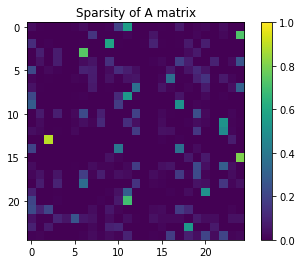

In [11]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from matplotlib import animation
from matplotlib.animation import FuncAnimation


plt.imshow(A, vmax=1.0)
plt.colorbar()
plt.title('Sparsity of A matrix')
plt.show()


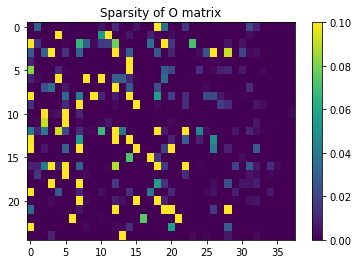

In [12]:
plt.imshow(np.array(O)[:, :O.shape[1]], vmax=0.1, aspect='auto')
plt.colorbar()
plt.title('Sparsity of O matrix')
plt.show()


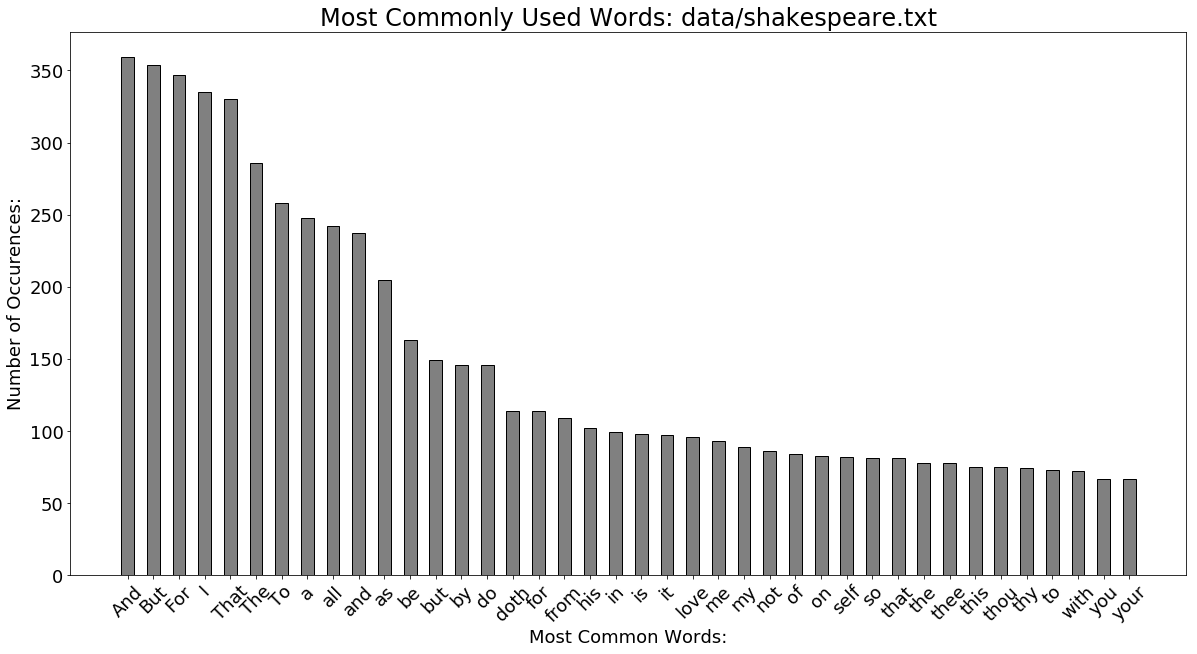

In [54]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

# with open('data/shakespeare.txt') as f:
#     text = f.read()
#     text = text.lower()

f = open('data/shakespeare.txt','r')
text = f.readlines()
# text = text.lower()
# f = open(os.getcwd()+'/data/shakespeare.txt')
# lines = f.readlines()
# lines = lines.lower()
# texts = [[word.lower() for word in line.split()] for line in data]

# text_b= [line.strip() for line in open('data/shakespeare.txt','r')]
# words = [[word.lower() for word in text.split()] for text in text_b]
words = [x for y in [l.split() for l in text] for x in y]
data = sorted([(w, words.count(w)) for w in set(words)], key = lambda x:x[1], reverse=True)[:40] 
most_words = [x[0] for x in data]
times_used = [int(x[1]) for x in data]
plt.figure(figsize=(20,10))
plt.bar(x=sorted(most_words), height=times_used, color = 'grey', edgecolor = 'black',  width=.5)
plt.xticks(rotation=45, fontsize=18)
plt.yticks(rotation=0, fontsize=18)
plt.xlabel('Most Common Words:', fontsize=18)
plt.ylabel('Number of Occurences:', fontsize=18)
plt.title('Most Commonly Used Words: %s' % ('data/shakespeare.txt'), fontsize=24)
plt.show()

In [48]:
data = [line.strip() for line in open('data/shakespeare.txt', 'r')]
texts = [[word.lower() for word in text.split()] for text in data]

In [56]:
words.type

AttributeError: 'list' object has no attribute 'type'